In [31]:
import math
import sys
import numpy as np
import re
import string
import random
from random import randint
import cv2
import os

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image, ImageFont, ImageDraw
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plti

%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda/

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda/


In [32]:
# CONSTANTS
IM_PATH = "/home/fizzer/labelled_plates"
DST_PATH = "/home/fizzer/labelled_dsts"
NUM_LABELS = 26
CONFIDENCE_THRESHOLD = 0.01
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 1e-4
HSV_LOWER = np.array([115,80,90])
HSV_UPPER = np.array([130,255,205])
DST_LOWER = np.array([0,0,0])
DST_UPPER = np.array([0,0,90])

In [33]:
# PLATES
# CP_PATH = "/home/fizzer/cnn_trainer/letter_model/cps/"
# SAVE_PATH = "/home/fizzer/cnn_trainer/letter_model/save/"

In [34]:
# DSTS
CP_PATH = "/home/fizzer/cnn_trainer/dst_model/cps/"
SAVE_PATH = "/home/fizzer/cnn_trainer/dst_model/save/"

In [35]:
# Set up one hot reference 
one_hot_ref = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
def one_hot_map(c):
    arr = np.zeros(len(one_hot_ref))
    arr[one_hot_ref.find(c)] = 1
    return arr

In [36]:
i = cv2.imread(f"{IM_PATH}/PLT_000013_IP61.png")
hsv = cv2.cvtColor(i, cv2.COLOR_BGR2HSV)
blur = cv2.GaussianBlur(hsv, (5,5), cv2.BORDER_DEFAULT)
# Mask -> Get contours -> Take 4 Largest contours
i_mask = cv2.inRange(blur, HSV_LOWER, HSV_UPPER)
contours, _ = cv2.findContours(i_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts_sorted = np.flip(sorted(contours, key=lambda x: cv2.contourArea(x))[-4:])
# Sort contours left to right
rects = []
for cnt in cnts_sorted:
    x,y,w,h = cv2.boundingRect(cnt)
    rects.append([x,y,w,h])
rects = np.array(rects)
rects = sorted(rects, key=lambda x: x[0])
# Show a slice
x,y,w,h = rects[0]
cv2.imshow("img", i_mask[y:y+h,x:x+w])
cv2.waitKey(1)

-1

In [37]:
KERNEL = np.ones((3,3), np.uint8)
def get_char(img, char, rect):
    x,y,w,h = rect
    im = cv2.resize(img[y:y+h,x:x+w], (75,100))
    im = cv2.erode(cv2.dilate(im, KERNEL, iterations=1), KERNEL, iterations=1)
    return (one_hot_map(char), im)

In [38]:
# THIS IS FOR READING THE PLATE NUMBERS/LETTERS
def crop_plate(plate_path):
    img = cv2.imread(f"{IM_PATH}/{plate_path}")
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    blur = cv2.GaussianBlur(hsv, (3,3), cv2.BORDER_DEFAULT)
    mask = cv2.inRange(blur, HSV_LOWER, HSV_UPPER)
    # Mask -> Get contours -> Take 4 Largest contours
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts_sorted = np.flip(sorted(contours, key=lambda x: cv2.contourArea(x))[-4:])
    rects = []
    for cnt in cnts_sorted:
        x,y,w,h = cv2.boundingRect(cnt)
        rects.append([x,y,w,h])
    rects = np.array(rects)
    rects = sorted(rects, key=lambda x: x[0])
    # Perform image processing
    return get_char(mask, plate_path[-8], rects[0]), get_char(mask, plate_path[-7], rects[1]), get_char(mask, plate_path[-6], rects[2]), get_char(mask, plate_path[-5], rects[3])

In [39]:
# THIS IS FOR READING THE "CAR NUMBER"
def crop_dst(plate_path):
    img = cv2.imread(f"{DST_PATH}/{plate_path}")
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    blur = cv2.GaussianBlur(hsv, (3,3), cv2.BORDER_DEFAULT)
    mask = cv2.inRange(hsv, DST_LOWER, DST_UPPER)
    # Mask -> Get contours -> Take 4 Largest contours
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts_sorted = np.flip(sorted(contours, key=lambda x: cv2.contourArea(x))[-2:])
    rects = []
    for cnt in cnts_sorted:
        x,y,w,h = cv2.boundingRect(cnt)
        rects.append([x,y,w,h])
    rects = np.array(rects)
    rects = sorted(rects, key=lambda x: x[0])
    return get_char(mask, plate_path[-5], rects[1])

In [40]:
imset = []

# Read plates
# dir_contents = np.array(os.listdir(IM_PATH))
# for im_path in dir_contents:
#    # Plates
#    p1,p2,p3,p4 = crop_plate(im_path)
#    imset.extend([p1,p2,p3,p4])

# Read dsts
dir_contents = np.array(os.listdir(DST_PATH))
for im_path in dir_contents:
  # DSTs
   p1 = crop_dst(im_path)
   imset.extend([p1])

dataset = np.array(imset)
np.random.shuffle(dataset)

/tmp/ipykernel_14790/1486754096.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(imset)


In [41]:
x_dataset = np.array([img[1][:] for img in imset[:]])
y_dataset = np.array([img[0] for img in imset[:]])
x_dataset = x_dataset/255.0
x_dataset = x_dataset.reshape(len(x_dataset), len(x_dataset[0]), len(x_dataset[0][0]), -1)
print(x_dataset.shape)

(258, 100, 75, 1)


In [42]:
# TODO: The following was copy pasted - validate
def reset_weights(model):
    for ix, layer in enumerate(model.layers):
        if (hasattr(model.layers[ix], 'kernel_initializer') and 
            hasattr(model.layers[ix], 'bias_initializer')):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer = model.layers[ix].bias_initializer

            old_weights, old_biases = model.layers[ix].get_weights()

            model.layers[ix].set_weights([
                weight_initializer(shape=old_weights.shape),
                bias_initializer(shape=len(old_biases))])

In [43]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(100, 75, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(36, activation='softmax'))
cp_callback = callbacks.ModelCheckpoint(filepath=CP_PATH, save_weights_only=True, verbose=1)

In [44]:
LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])

In [45]:
history_conv = conv_model.fit(x_dataset, y_dataset, 
                              validation_split=VALIDATION_SPLIT, 
                              epochs=10, 
                              batch_size=16,
                              callbacks=[cp_callback])

Epoch 1/10


2022-12-07 11:02:57.767784: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:433] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2022-12-07 11:02:57.767834: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops_fused_impl.h:621 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Graph execution error:

Detected at node 'sequential_2/conv2d_8/Relu' defined at (most recent call last):
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_14790/2630715620.py", line 1, in <module>
      history_conv = conv_model.fit(x_dataset, y_dataset,
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 314, in call
      return self.activation(outputs)
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/backend.py", line 5369, in relu
      x = tf.nn.relu(x)
Node: 'sequential_2/conv2d_8/Relu'
DNN library is not found.
	 [[{{node sequential_2/conv2d_8/Relu}}]] [Op:__inference_train_function_3763]

In [ ]:
conv_model.save(SAVE_PATH)

INFO:tensorflow:Assets written to: /home/fizzer/cnn_trainer/dst_model/save/assets


INFO:tensorflow:Assets written to: /home/fizzer/cnn_trainer/dst_model/save/assets


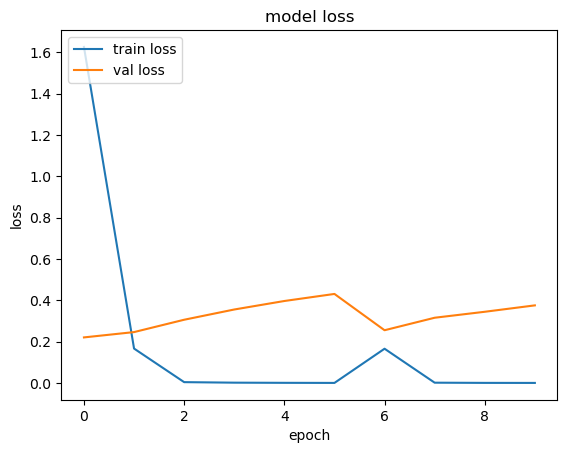

In [ ]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

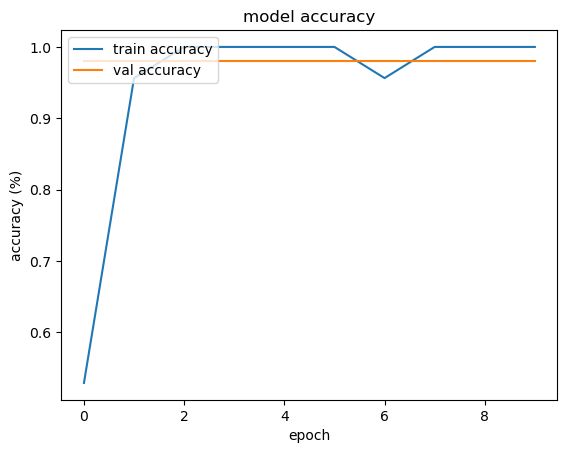

In [ ]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pred_matrix = conv_model.predict(x_dataset)

pred_results = [np.argmax(pred) for pred in pred_matrix]
corr_results = [np.argmax(Y_val) for Y_val in y_dataset]

conf_matrix = confusion_matrix(corr_results, pred_results)

df_cm = pd.DataFrame(conf_matrix, index = [i for i in one_hot_ref],
                  columns = [i for i in one_hot_ref])
plt.figure(figsize = (15,8))
sn.heatmap(df_cm, annot=True)

9/9 [==============================] - 0s 1ms/step


ValueError: Shape of passed values is (9, 9), indices imply (36, 36)

In [ ]:
pred_matrix = conv_model.predict(x_dataset)
pred_results = [np.argmax(pred) for pred in pred_matrix]
corr_results = [np.argmax(Y_val) for Y_val in y_dataset]

35/35 [==============================] - 0s 1ms/step


In [ ]:
print(conv_model.predict(x_dataset)[0])

35/35 [==============================] - 0s 1ms/step
[5.1432079e-21 2.1208761e-26 2.5950668e-17 2.2889838e-26 6.2554613e-21
 3.7961851e-21 1.3952884e-19 1.1685697e-23 1.8904996e-22 5.2487210e-25
 6.9459746e-18 5.6754574e-18 8.1698799e-19 7.8372120e-16 2.2462316e-22
 3.4031993e-23 1.1156070e-21 1.8785873e-22 2.3737680e-16 1.6713504e-26
 6.0729007e-16 1.1533691e-18 1.8013260e-24 1.0000000e+00 2.5093962e-11
 4.2130148e-16 1.0010041e-22 1.7637690e-12 4.8227003e-22 4.4362456e-20
 6.5635662e-16 2.2877249e-20 1.3387562e-14 1.7526135e-14 4.5718736e-17
 5.3969282e-21]
